In [115]:
import numpy as np
import matplotlib.pyplot as plt

from astropy.wcs import WCS
from astropy.io import fits
from astropy.utils.data import get_pkg_data_filename
from astropy.nddata import Cutout2D
import os

In [1]:
def find_cutout(filename_345s, filename_33s, size_345s, x_345s, y_345s):
    cutout_345 = []
    cutout_33 = []
    for filename_345, filename_33, size_345, x_345, y_345 in zip(filename_345s, filename_33s, size_345s, x_345s, y_345s):
        hdu_345 = fits.open(filename_345)[0]
        wcs_345 = WCS(hdu_345.header, relax=True, naxis=2)
        hdu_33 = fits.open(filename_33)[0]
        wcs_33 = WCS(hdu_33.header, relax=True, naxis=2)

        #converting the position information between different datasets
        sky = wcs_345.pixel_to_world(x_345, y_345)    #position
        x_33, y_33 = wcs_33.world_to_pixel(sky)

        margin_345 = wcs_345.pixel_to_world(x_345 - size_345/2, y_345 - size_345/2)    #size
        x_33_margin, y_33_margin = wcs_33.world_to_pixel(margin_345)
        size_33 = 2 * (x_33 - x_33_margin)

        #doing the cutout
        cutout_345.append(Cutout2D(hdu_345.data[0][0], (x_345, y_345), size_345, wcs=wcs_345, copy=True))
        cutout_33.append(Cutout2D(hdu_33.data[0][0], (x_33, y_33), size_33, wcs=wcs_33, copy=True))
        
    return cutout_345, cutout_33

def gen_axis(cutout_345s):
    axs = []
#     subplot_nums = [241, 242, 243, 244, 245, 246, 247]
    subplot_nums = [111]
    for subplot_num, cutout_345 in zip(subplot_nums[:len(cutout_345s)], cutout_345s):
        axs.append(plt.subplot(subplot_num, projection=cutout_345.wcs))
    return axs
def gen_axises(cutout_345s):
    axs = []
    subplot_nums = [241, 242, 243, 244, 245, 246, 247]

    for subplot_num, cutout_345 in zip(subplot_nums[:len(cutout_345s)], cutout_345s):
        axs.append(plt.subplot(subplot_num, projection=cutout_345.wcs))
    return axs

def plot_contour(axs,cutout_345s, cutout_33s, levs, vmins, vmaxs):
    
    for ax, cutout_345, cutout_33, level, vmi, vma in zip(axs, cutout_345s, cutout_33s, levs, vmins, vmaxs):
        ax.set_xlabel('Right Ascension')
        ax.set_ylabel('Declination')
        #filename
#         ax.imshow(cutout_345.data, vmin=-5e-5, vmax=5e-3, origin='lower')
        ax.imshow(cutout_345.data, vmin=vmi, vmax=vma, origin='lower')
        ax.contour(cutout_33.data, transform=ax.get_transform(cutout_33.wcs), \
               levels=[9.07e-6 * 3,9.07e-6 * 6,9.07e-6 * 9 ], colors=['c','yellow','white'])
        ax.set_xlim(0,221)


def plot_disk(axs, cutout_345s, vmins, vmaxs):
    ax.set_xlabel('Right Ascension')
    ax.set_ylabel('Declination')
    ax.imshow(cutout_345.data, vmin=vmi, vmax=vma)

indices in parameterized keywords must not have leading zeroes. [astropy.wcs.wcs]
indices in parameterized keywords must not have leading zeroes. [astropy.wcs.wcs]
indices in parameterized keywords must not have leading zeroes. [astropy.wcs.wcs]
indices in parameterized keywords must not have leading zeroes. [astropy.wcs.wcs]
indices in parameterized keywords must not have leading zeroes. [astropy.wcs.wcs]
indices in parameterized keywords must not have leading zeroes. [astropy.wcs.wcs]
indices in parameterized keywords must not have leading zeroes. [astropy.wcs.wcs]
indices in parameterized keywords must not have leading zeroes. [astropy.wcs.wcs]
indices in parameterized keywords must not have leading zeroes. [astropy.wcs.wcs]
indices in parameterized keywords must not have leading zeroes. [astropy.wcs.wcs]
indices in parameterized keywords must not have leading zeroes. [astropy.wcs.wcs]
indices in parameterized keywords must not have leading zeroes. [astropy.wcs.wcs]
indices in param

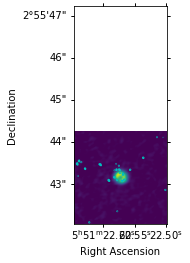

In [2]:
# %matplotlib notebook

# filename_345 = ['data/HH270MMS2_345GHz.fits', 'data/HOPS-56_345GHz.fits', 'data/HOPS-65_345GHz.fits',\
#                'data/HOPS-124_345GHz.fits', 'data/HOPS-140_345GHz.fits', 'data/HOPS-157_345GHz.fits',\
#                'data/HOPS-163_345GHz.fits'] 
# filename_33 = ['data/HH270MMS2_44GHz_robust2.0.fits', 'data/HOPS-56_33GHz_robust2.0.fits', 'data/HOPS-65_15GHz_robust2.0.fits',\
#               'data/HOPS-124_44GHz_robust2.0.fits', 'data/HOPS-140_33GHz_robust2.0.fits', 'data/HOPS-157_33GHz_robust2.0.fits',\
#               'data/HOPS-163_33GHz_robust2.0.fits']
# size_345 = [221, 221, 221, 221, 271, 221, 221]
# x_345 = [490, 1566, 478, 621, 1517, 498, 514] 
# y_345 = [549, 938, 496, 505, 1487, 479, 511] 
# rms_33 = [9.07e-6, 5.3e-6, 2.4e-6, 1.47e-5, 4.96e-6, 5.15e-6, 5.11e-6]
filename_345 = ['data/HH270MMS2_345GHz.fits']
filename_33 = ['data/HH270MMS2_44GHz_robust2.0.fits']
size_345 = [221]
x_345 = [490]
y_345 = [549]
v_min = [-5e-6]
v_max= [15e-3]
rms_33 = [9.07e-6]
level = [[rms_33 * 3,rms_33 * 6,rms_33 * 9 ]]
cutout_345, cutout_33 = find_cutout(filename_345s = filename_345, filename_33s = filename_33, size_345s=size_345, x_345s=x_345, y_345s=y_345)
axs = gen_axis(cutout_345)
plot_contour(axs,cutout_345, cutout_33, levs=level, vmins = v_min, vmaxs = v_max)

In [68]:
# plt.imshow(cutout_345[0].data)
cutout_345[0].data.size

48841

In [69]:
cutout_33[0].data.size

268324

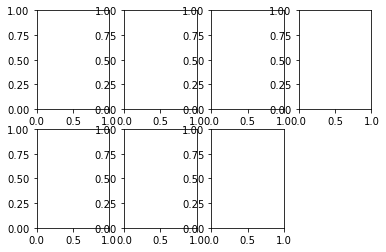

In [7]:
import matplotlib.pyplot as plt
# def gen_axis(cutout_345s):
axs = []
subplot_nums = [241, 242, 243, 244, 245, 246, 247]
for subplot_num in subplot_nums:
    axs.append(plt.subplot(subplot_num))

In [116]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.wcs import WCS
from astropy.io import fits
from astropy.utils.data import get_pkg_data_filename
from astropy.nddata import Cutout2D
import os

In [155]:
def find_levels(rmss, n_rms_levels):
    levels = []
    for rms, n in zip(rmss, n_rms_levels):
        levels.append(n * rms)
    return levels


def find_cutout(filename_345s, filename_33s, size_345s, x_345s, y_345s):
    cutout_345 = []
    cutout_33 = []
    for filename_345, filename_33, size_345, x_345, y_345 in zip(filename_345s, filename_33s, size_345s, x_345s,
                                                                 y_345s):
        hdu_345 = fits.open(filename_345)[0]
        wcs_345 = WCS(hdu_345.header, relax=True, naxis=2)
        hdu_33 = fits.open(filename_33)[0]
        wcs_33 = WCS(hdu_33.header, relax=True, naxis=2)

        # converting the position information between different datasets
        sky = wcs_345.pixel_to_world(x_345, y_345)  # position
        x_33, y_33 = wcs_33.world_to_pixel(sky)

        margin_345 = wcs_345.pixel_to_world(x_345 - size_345 / 2, y_345 - size_345 / 2)  # size
        x_33_margin, y_33_margin = wcs_33.world_to_pixel(margin_345)
        size_33 = 2 * (x_33 - x_33_margin)

        # doing the cutout
        cutout_345.append(Cutout2D(hdu_345.data[0][0], (x_345, y_345), size_345, wcs=wcs_345, copy=True))
        cutout_33.append(Cutout2D(hdu_33.data[0][0], (x_33, y_33), size_33, wcs=wcs_33, copy=True))

#     print(cutout_33[0].data.shape)
#     print(hdu_33.data.shape)
    return cutout_345, cutout_33


def gen_axis(cutout_345s):
    axs = []
    #     subplot_nums = [241, 242, 243, 244, 245, 246, 247]
    subplot_nums = [111]
    for subplot_num, cutout_345 in zip(subplot_nums[:len(cutout_345s)], cutout_345s):
        axs.append(plt.subplot(subplot_num, projection=cutout_345.wcs))
    return axs


def gen_axises(cutout_345s):
    axs = []
    subplot_nums = [241, 242, 243, 244, 245, 246, 247]

    for subplot_num, cutout_345 in zip(subplot_nums[:len(cutout_345s)], cutout_345s):
        axs.append(plt.subplot(subplot_num, projection=cutout_345.wcs))
    return axs


def plot_contour(obj_name, axs, cutout_345s, cutout_33s, pixel_sizes, levs, vmins, vmaxs, save_fig):
    # recieve a list of objs
    for ax, cutout_345, cutout_33, pixel_size, level, vmi, vma in zip(axs, cutout_345s, cutout_33s, pixel_sizes, levs, vmins, vmaxs):
        ax.set_xlabel('Right Ascension', fontsize=14)
        ax.set_ylabel('Declination', fontsize=14)

        ax.imshow(cutout_345.data, vmin=vmi, vmax=vma, origin='lower')
        ax.contour(cutout_33.data, transform=ax.get_transform(cutout_33.wcs), \
                   levels=level, colors=['c', 'yellow', 'white'])
        
        ax.set_xlim(0, pixel_size)
        ax.set_ylim(0, pixel_size)
        plt.title(f'{obj_name}', fontsize=17)
        
        if save_fig == True:
            direc = 'pictures_contours'
            os.makedirs(direc, exist_ok=True)
            plt.savefig(os.path.join(direc, f'{obj_name}_contours_zoom_in.pdf'), bbox_inches='tight')
            plt.close()

            
def plot_disk(save_fig):
    tested_objs = ['HH270MMS2','HOPS-56',  'HOPS-65', 'HOPS-124', 'HOPS-140', 'HOPS-157', 'HOPS-163']

    f,axss = plt.subplots(2, 4,figsize=(16,8))
    f.suptitle('Disk Image (345GHz)',fontsize = 16)
    axes = [axss[0,0],axss[0,1],axss[0,2],axss[0,3],axss[1,0],axss[1,1],axss[1,2]]
    axss[1,3].axis("off")
    for obj,axs in zip(tested_objs,axes):
        print(axs)
        size_345 = [target_pixel_sizes[obj]]
        x_345 = [x_345s[obj]]
        y_345 = [y_345s[obj]]
        v_min = v_mins[obj]
        v_max= v_maxs[obj]
        filename_345 = [f'data/{obj}_345GHz.fits']
        filename_33 = [f'data/{obj}_{int(VLA_freq[obj])}GHz_robust2.0.fits']


        cutout_345, cutout_33 = find_cutout(filename_345s = filename_345, filename_33s = filename_33, size_345s=size_345, x_345s=x_345, y_345s=y_345)
        axs.imshow(cutout_345[0].data, vmin=v_min, vmax=v_max)
        axs.set_title(obj)
    if save_fig == True:
        direc = 'pictures_disks'
        os.makedirs(direc, exist_ok=True)
        plt.savefig(os.path.join(direc, f'Disk_Image.pdf'))
        plt.close()



In [156]:
# parameters in dictionaries:
VLA_freq = {'HH270MMS2':44 , 'HOPS-56':33 ,  'HOPS-65':15 , 'HOPS-124':44 , 'HOPS-140':33 , 'HOPS-157':33 , 'HOPS-163':33  }

target_pixel_sizes = {'HH270MMS2': 91 , 'HOPS-56': 151 ,  'HOPS-65': 191 , 'HOPS-124':101 , 'HOPS-140': 191 , 'HOPS-157':141 , 'HOPS-163':131  }
x_345s = {'HH270MMS2': 490, 'HOPS-56': 1556,  'HOPS-65': 478, 'HOPS-124': 621, 'HOPS-140':1517 , 'HOPS-157': 498 , 'HOPS-163': 514 }
y_345s = {'HH270MMS2': 549, 'HOPS-56': 942 ,  'HOPS-65': 490, 'HOPS-124':505 , 'HOPS-140': 1487, 'HOPS-157':490 , 'HOPS-163': 511 }

rms_VLAs = {'HH270MMS2': 9.07e-6, 'HOPS-56': 5.3e-6,  'HOPS-65': 2.4e-6, 'HOPS-124': 1.47e-5 , 'HOPS-140':4.96e-6 , 'HOPS-157':5.15e-6 , 'HOPS-163':5.11e-6  }

v_mins = {'HH270MMS2':-5e-6 , 'HOPS-56': -5e-4,  'HOPS-65': -5e-4, 'HOPS-124': -5e-4 , 'HOPS-140':-5e-5 , 'HOPS-157':-5e-5 , 'HOPS-163': -5e-5 }
v_maxs = {'HH270MMS2':15e-3 , 'HOPS-56': 6e-3,  'HOPS-65': 3e-3 , 'HOPS-124':5e-2 , 'HOPS-140':3e-3 , 'HOPS-157': 3e-3, 'HOPS-163':5e-3  }

# n_levels = [3,4,5]
n_levels = {'HH270MMS2': [3,6,9] , 'HOPS-56':[3,6,9] ,  'HOPS-65': [3,5,7], 'HOPS-124':[6,12,18] , 'HOPS-140':[3,4,5] , 'HOPS-157':[3,6,9] , 'HOPS-163': [3,4,5] }


indices in parameterized keywords must not have leading zeroes. [astropy.wcs.wcs]
indices in parameterized keywords must not have leading zeroes. [astropy.wcs.wcs]
indices in parameterized keywords must not have leading zeroes. [astropy.wcs.wcs]
indices in parameterized keywords must not have leading zeroes. [astropy.wcs.wcs]
indices in parameterized keywords must not have leading zeroes. [astropy.wcs.wcs]
indices in parameterized keywords must not have leading zeroes. [astropy.wcs.wcs]
indices in parameterized keywords must not have leading zeroes. [astropy.wcs.wcs]
indices in parameterized keywords must not have leading zeroes. [astropy.wcs.wcs]
indices in parameterized keywords must not have leading zeroes. [astropy.wcs.wcs]
indices in parameterized keywords must not have leading zeroes. [astropy.wcs.wcs]
indices in parameterized keywords must not have leading zeroes. [astropy.wcs.wcs]
indices in parameterized keywords must not have leading zeroes. [astropy.wcs.wcs]
indices in param

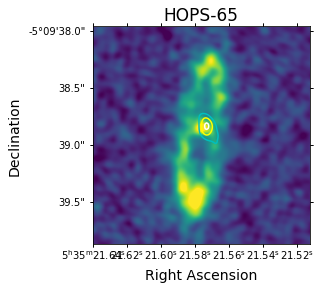

In [157]:
tested_obj = 'HOPS-65'

# parameter preparation for test objects
filename_345 = [f'data/{tested_obj}_345GHz.fits']
filename_33 = [f'data/{tested_obj}_{int(VLA_freq[tested_obj])}GHz_robust2.0.fits']

size_345 = [target_pixel_sizes[tested_obj]]
x_345 = [x_345s[tested_obj]]
y_345 = [y_345s[tested_obj]]
v_min = [v_mins[tested_obj]]
v_max = [v_maxs[tested_obj]]
rms_33 = [rms_VLAs[tested_obj]]
level = find_levels(rms_33, [np.array(n_levels[tested_obj])])


# get cutout and plot contour
cutout_345, cutout_33 = find_cutout(filename_345s=filename_345, filename_33s=filename_33, size_345s=size_345,
                                    x_345s=x_345, y_345s=y_345)
axs = gen_axis(cutout_345)
plot_contour(tested_obj, axs, cutout_345, cutout_33, pixel_sizes=size_345, levs=level, vmins=v_min, vmaxs=v_max, save_fig=False)

# plot_disk(True)


In [158]:
# save plot for all disks
tested_objs = ['HH270MMS2','HOPS-56',  'HOPS-65', 'HOPS-124', 'HOPS-140', 'HOPS-157', 'HOPS-163']  
for tested_obj in tested_objs:

    # parameter preparation for test objects
    filename_345 = [f'data/{tested_obj}_345GHz.fits']
    filename_33 = [f'data/{tested_obj}_{int(VLA_freq[tested_obj])}GHz_robust2.0.fits']

    size_345 = [target_pixel_sizes[tested_obj]]
    x_345 = [x_345s[tested_obj]]
    y_345 = [y_345s[tested_obj]]
    v_min = [v_mins[tested_obj]]
    v_max = [v_maxs[tested_obj]]
    rms_33 = [rms_VLAs[tested_obj]]
    level = find_levels(rms_33, [np.array(n_levels[tested_obj])])

    # get cutout and plot contour
    cutout_345, cutout_33 = find_cutout(filename_345s=filename_345, filename_33s=filename_33, size_345s=size_345,
                                        x_345s=x_345, y_345s=y_345)
    axs = gen_axis(cutout_345)
    plot_contour(tested_obj, axs, cutout_345, cutout_33, pixel_sizes=size_345, levs=level, vmins=v_min, vmaxs=v_max, save_fig=True)


indices in parameterized keywords must not have leading zeroes. [astropy.wcs.wcs]
indices in parameterized keywords must not have leading zeroes. [astropy.wcs.wcs]
indices in parameterized keywords must not have leading zeroes. [astropy.wcs.wcs]
indices in parameterized keywords must not have leading zeroes. [astropy.wcs.wcs]
indices in parameterized keywords must not have leading zeroes. [astropy.wcs.wcs]
indices in parameterized keywords must not have leading zeroes. [astropy.wcs.wcs]
indices in parameterized keywords must not have leading zeroes. [astropy.wcs.wcs]
indices in parameterized keywords must not have leading zeroes. [astropy.wcs.wcs]
indices in parameterized keywords must not have leading zeroes. [astropy.wcs.wcs]
indices in parameterized keywords must not have leading zeroes. [astropy.wcs.wcs]
indices in parameterized keywords must not have leading zeroes. [astropy.wcs.wcs]
indices in parameterized keywords must not have leading zeroes. [astropy.wcs.wcs]
indices in param

Set OBSGEO-B to   -23.022886 from OBSGEO-[XYZ].
Set OBSGEO-H to     5053.796 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to    34.078827 from OBSGEO-[XYZ].
Set OBSGEO-H to     2115.607 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
indices in parameterized keywords must not have leading zeroes. [astropy.wcs.wcs]
indices in parameterized keywords must not have leading zeroes. [astropy.wcs.wcs]
indices in parameterized keywords must not have leading zeroes. [astropy.wcs.wcs]
indices in parameterized keywords must not have leading zeroes. [astropy.wcs.wcs]
indices in parameterized keywords must not have leading zeroes. [astropy.wcs.wcs]
indices in parameterized keywords must not have leading zeroes. [astropy.wcs.wcs]
indices in parameterized keywords must not have leading zeroes. [astropy.wcs.wcs]
indices in parameterized keywords must not have leading zeroes. [astropy.wcs.wcs]
indices in parameterized keywords must not have leading zeroes. [astropy.wcs.wcs]
indices in parameterized keyword